In [ ]:
# learning using a CNN

# CNN for learning!

# learn the states of a double dot
import numpy as np
import tensorflow as tf
import glob
import os
import time

from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib

tf.logging.set_verbosity(tf.logging.INFO)

# application logic will be added here
def cnn_model_fn(features,labels,mode):
    '''Model function for CNN'''
    #input layer
    input_layer = tf.cast(tf.reshape(features,[-1,30,30,1]),tf.float32)
    
    conv1 = tf.layers.conv2d(inputs=input_layer,
                            filters=32,
                            kernel_size=[5,5],
                            padding="same",
                            activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2],strides=2)
    
    conv2 = tf.layers.conv2d(inputs=pool1,
                            filters=64,
                            kernel_size=[5,5],
                            padding="same",
                            activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2],strides=2)
    
    flat = tf.contrib.layers.flatten(inputs=pool2)
    # dense output layer
    out1 = tf.layers.dense(inputs=flat,units=1024,activation=tf.nn.relu)  
    dropout1 = tf.layers.dropout(
      inputs=out1, rate=0.4, training=mode == learn.ModeKeys.TRAIN)
    
    out = tf.layers.dense(inputs=dropout1, units=4)

    loss = None
    train_op = None

    # Calculate loss( for both TRAIN AND EVAL modes)
    if mode != learn.ModeKeys.INFER:
        #onehot_labels = tf.one_hot(indices=tf.cast(labels,tf.int32),depth=4)
        #loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels,logits=out)
        loss = tf.losses.mean_squared_error(out,labels)

    # Configure the training op (for TRAIN mode)
    if mode == learn.ModeKeys.TRAIN:
        train_op = tf.contrib.layers.optimize_loss(
            loss=loss,
            global_step=tf.contrib.framework.get_global_step(),
            learning_rate=1e-3,
            optimizer=tf.train.AdamOptimizer)

    # Generate predictions
    predictions= {
        "prob" : out,
        "states" : tf.argmax(out,axis=1),
    }

    # Returna  ModelFnOps object
    return model_fn_lib.ModelFnOps(mode=mode,predictions=predictions,loss=loss, train_op=train_op)
    
def get_train_inputs():
    n_batch = 100
    index = np.random.choice(n_train,n_batch,replace=False)
    inp = []
    oup = []
    for i in index:
        dat = np.load(files[i])
        inp += [dat.item()['current_map']]
        oup += [dat.item()['label']]

    inp = np.array(inp,dtype=np.float32)
    oup = np.array(oup,dtype=np.float32)
    
    x = tf.constant(inp)
    y = tf.constant(oup)
    return x,y

def get_test_inputs():
    inp = []
    oup = []
       
    for file in files[n_train:]:
        dat = np.load(file)
        inp += [dat.item()['current_map']]
        oup += [dat.item()['label']]
    
    inp = np.array(inp)
    oup = np.array(oup)
    
    x = tf.constant(inp)
    y = tf.constant(oup)
    return x,y


# get the data
data_folder_path = "/Users/ssk4/Downloads/data_subimage/"
files = glob.glob(data_folder_path + "*.npy")

# shuffling the files to avoid any single dot bias
import random
random.shuffle(files)
files = files[:10000]

n_samples = len(files)
train_sample_ratio = 0.8
n_train = int(train_sample_ratio * n_samples)

print("Total number of samples :",n_samples)
print("Training samples :",n_train)
print("Test samples :",n_samples - n_train)

st = time.time()
# create the estimator
dd_classifier = learn.Estimator(model_fn=cnn_model_fn)

# set up logging for predictions
tensors_to_log = {}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=100)

metrics = {
    "accuracy" : learn.MetricSpec(metric_fn=tf.metrics.accuracy, prediction_key="states"),
}


dd_classifier.fit(
    input_fn=get_train_inputs,
    steps=10000,
    monitors=[logging_hook])


# Evaluate accuracy.
accuracy_score = dd_classifier.evaluate(input_fn=get_train_inputs,metrics=metrics,
                                       steps=1)["accuracy"]
print("\nTrain Accuracy: {0:f}\n".format(accuracy_score))

# Evaluate accuracy.
accuracy_score = dd_classifier.evaluate(input_fn=get_test_inputs,metrics=metrics,
                                       steps=1)["accuracy"]
print("\nTest Accuracy: {0:f}\n".format(accuracy_score))



print("Training done in",time.time()-st,"seconds.")




Total number of samples : 10000
Training samples : 8000
Test samples : 2000
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x118e14eb8>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': None}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/hs/nm7qn85519v78y5bbl49h61h001sq3/T/tmp0ynfinz0/model.ckpt.
INFO:tensorflow:loss = 0.204952, step = 1
INFO:tensorflow:


In [44]:
accuracy_score = dd_classifier.evaluate(input_fn=get_test_inputs,
                                       steps=1,metrics=metrics)

ValueError: Features are incompatible with given information. Given features: Tensor("Const:0", shape=(200, 30, 30), dtype=float64), required signatures: TensorSignature(dtype=tf.float32, shape=TensorShape([Dimension(100), Dimension(30), Dimension(30)]), is_sparse=False).

In [45]:
pred = dd_classifier.predict(input_fn=get_test_inputs,as_iterable=False)

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Restoring parameters from /var/folders/hs/nm7qn85519v78y5bbl49h61h001sq3/T/tmpx2nwitym/model.ckpt-5318


In [102]:
curr = sess.run(x)
curr

array([], dtype=float64)

In [98]:
sess = tf.Session()
x,y = get_test_inputs()
st = tf.argmax(y,axis=1)
curr = sess.run(x)
out = sess.run(st)
print(out)

InvalidArgumentError: Expected dimension in the range [-1, 1), but got 1
	 [[Node: ArgMax_13 = ArgMax[T=DT_DOUBLE, Tidx=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](Const_32, ArgMax_13/dimension)]]

Caused by op 'ArgMax_13', defined at:
  File "/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-98-45fc316a9b44>", line 3, in <module>
    st = tf.argmax(y,axis=1)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 178, in argmax
    return gen_math_ops.arg_max(input, axis, name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 188, in arg_max
    name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Expected dimension in the range [-1, 1), but got 1
	 [[Node: ArgMax_13 = ArgMax[T=DT_DOUBLE, Tidx=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](Const_32, ArgMax_13/dimension)]]


In [50]:
diff = out - pred['states']

In [56]:
list(diff).count(0)/len(diff)

0.96

In [104]:
# Testing of the experimental data loading
import numpy as np
import scipy.interpolate

data_folder_path = "/Users/ssk4/Downloads/exp_data/"
files = glob.glob(data_folder_path + "*.dat")

# Data format is V_LGD I_DC(nA) V_LGS I_AC(nA) t(sec)
# The format of the loaded array is [num_points,5]
index = np.random.randint(len(files))

for i in range(len(files)):

    dat = np.loadtxt(files[i])

    sub_size = 30
    grid_x = np.linspace(np.min(dat[:,0]),np.max(dat[:,0]),sub_size)
    grid_y = np.linspace(np.min(dat[:,2]),np.max(dat[:,2]),sub_size)
    xx,yy = np.meshgrid(grid_x,grid_y)
    interpolated_data = scipy.interpolate.griddata((dat[:,0],dat[:,2]),dat[:,1],(xx, yy), method='nearest')
    tf.logging.set_verbosity(tf.logging.ERROR)
    #import matplotlib.pyplot as plt
    #%matplotlib inline
    #plt.pcolor(interpolated_data)

    print(i,dd_classifier.predict(x=interpolated_data,as_iterable=False)['states'])

0 [2]
1 [2]
2 [3]
3 [2]
4 [3]
5 [2]
6 [2]
7 [2]
8 [2]
9 [2]
10 [2]
11 [2]
12 [2]
13 [2]
14 [2]
15 [2]
16 [2]
17 [2]
18 [2]
19 [3]
20 [2]
21 [2]
22 [2]
23 [2]
24 [2]
25 [2]
26 [2]
27 [2]
28 [2]
29 [2]
30 [3]
31 [3]
32 [2]
33 [2]
34 [2]
35 [3]
36 [2]
37 [2]
38 [2]
39 [2]
40 [2]
41 [2]
42 [2]
43 [2]
44 [2]
45 [2]
46 [2]
47 [2]
48 [2]
49 [2]
50 [2]
51 [2]
52 [2]
53 [2]


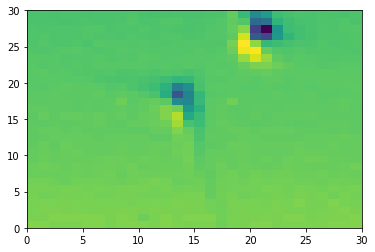

In [114]:
dat = np.loadtxt(files[20])

sub_size = 30
grid_x = np.linspace(np.min(dat[:,0]),np.max(dat[:,0]),sub_size)
grid_y = np.linspace(np.min(dat[:,2]),np.max(dat[:,2]),sub_size)
xx,yy = np.meshgrid(grid_x,grid_y)
interpolated_data = scipy.interpolate.griddata((dat[:,0],dat[:,2]),dat[:,1],(xx, yy), method='nearest')

import matplotlib.pyplot as plt
%matplotlib inline
plt.pcolor(interpolated_data)

In [115]:
interpolated_data

array([[ 0.0131284,  0.0130977,  0.0130165,  0.0130461,  0.0130579,
         0.0130705,  0.0130673,  0.013014 ,  0.013067 ,  0.0130673,
         0.0130742,  0.0130424,  0.0131063,  0.013041 ,  0.0130354,
         0.0130415,  0.0130442,  0.0129011,  0.0129984,  0.0130359,
         0.0130761,  0.0130623,  0.0130196,  0.0130593,  0.0130596,
         0.0130447,  0.013058 ,  0.0130686,  0.0130626,  0.0130784],
       [ 0.0130309,  0.0130342,  0.0130773,  0.013095 ,  0.0130655,
         0.0130709,  0.0130834,  0.0130363,  0.0130766,  0.0130537,
         0.012883 ,  0.0130093,  0.0130959,  0.0130351,  0.0130685,
         0.0130667,  0.0130831,  0.0129268,  0.0130313,  0.0130226,
         0.01302  ,  0.0130421,  0.0130307,  0.0130727,  0.0130674,
         0.013017 ,  0.013053 ,  0.0130509,  0.0130441,  0.0130853],
       [ 0.0130076,  0.0130482,  0.0130506,  0.0130161,  0.0130545,
         0.0130134,  0.0130176,  0.0130303,  0.0130606,  0.0130398,
         0.0130371,  0.0130427,  0.0130241,  0